Data: https://huggingface.co/datasets/Qdrant/NOAA-Buoy
Tutorial Credit: https://www.youtube.com/watch?v=c0k-YLQGKjY

# Single variable section

In [2281]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

In [2282]:
df = pd.read_csv('./full_years_remove_flawed_rows.csv')

In [2283]:
df['timestamp'] = pd.to_datetime(df['TSTMP'])
df.set_index('timestamp', inplace=True)
df.drop(['TSTMP'], axis=1, inplace=True)
df

,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP
timestamp,,,,,,,,,,,,,,,
1980-01-01 00:00:00-05:00,1980,1,1,0,0,323.0,10.6,14.3,1.80,5.90,5.10,NaN,1020.2,15.6,21.1
1980-01-01 01:00:00-05:00,1980,1,1,1,0,317.0,10.0,13.0,1.70,6.30,5.00,NaN,1020.7,15.6,21.1
1980-01-01 02:00:00-05:00,1980,1,1,2,0,323.0,9.4,12.3,1.80,6.30,4.90,NaN,1021.3,15.6,21.1
1980-01-01 03:00:00-05:00,1980,1,1,3,0,311.0,9.3,12.3,1.80,6.30,5.10,NaN,1021.8,15.7,21.2
1980-01-01 04:00:00-05:00,1980,1,1,4,0,324.0,8.2,10.9,1.80,6.70,5.20,NaN,1022.0,15.4,21.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 21:40:00-05:00,2022,12,31,21,40,82.0,2.3,3.3,1.27,8.33,6.18,101.0,1014.8,24.5,NaN
2022-12-31 22:10:00-05:00,2022,12,31,22,10,100.0,2.6,3.5,1.13,6.25,5.96,118.0,1014.9,24.5,NaN
2022-12-31 22:40:00-05:00,2022,12,31,22,40,110.0,3.2,4.5,1.22,7.69,6.19,100.0,1015.1,24.5,NaN


### This is a lot of data. Let's take periodic samples, every six hours

In [2284]:
df = df[df.index.hour % 6 == 0]
df

,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP
timestamp,,,,,,,,,,,,,,,
1980-01-01 00:00:00-05:00,1980,1,1,0,0,323.0,10.6,14.3,1.80,5.90,5.10,NaN,1020.2,15.6,21.1
1980-01-01 06:00:00-05:00,1980,1,1,6,0,339.0,8.1,10.3,1.60,6.70,5.10,NaN,1021.9,15.4,21.2
1980-01-01 12:00:00-05:00,1980,1,1,12,0,344.0,7.5,9.7,1.30,6.30,4.70,NaN,1020.7,15.4,21.1
1980-01-01 18:00:00-05:00,1980,1,1,18,0,352.0,5.3,7.6,1.10,5.90,4.80,NaN,1022.2,16.1,21.1
1980-01-02 00:00:00-05:00,1980,1,2,0,0,2.0,3.5,5.6,0.70,5.90,4.60,NaN,1020.0,15.7,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 06:40:00-05:00,2022,12,31,6,40,135.0,2.6,3.9,1.68,8.33,6.01,107.0,1014.5,24.6,NaN
2022-12-31 12:10:00-05:00,2022,12,31,12,10,259.0,3.4,5.0,1.57,7.69,6.19,115.0,1015.5,24.6,NaN
2022-12-31 12:40:00-05:00,2022,12,31,12,40,276.0,3.2,4.5,1.45,7.69,6.14,109.0,1015.8,24.6,NaN


## I dont want some of this data - it will not be useful

In [2285]:
df = df.drop(['#YY', 'MM', 'DD', 'hh', 'mm', 'DPD', 'APD'], axis=1)
df

,WDIR,WSPD,GST,WVHT,MWD,PRES,ATMP,WTMP
timestamp,,,,,,,,
1980-01-01 00:00:00-05:00,323.0,10.6,14.3,1.80,NaN,1020.2,15.6,21.1
1980-01-01 06:00:00-05:00,339.0,8.1,10.3,1.60,NaN,1021.9,15.4,21.2
1980-01-01 12:00:00-05:00,344.0,7.5,9.7,1.30,NaN,1020.7,15.4,21.1
1980-01-01 18:00:00-05:00,352.0,5.3,7.6,1.10,NaN,1022.2,16.1,21.1
1980-01-02 00:00:00-05:00,2.0,3.5,5.6,0.70,NaN,1020.0,15.7,21.0
...,...,...,...,...,...,...,...,...
2022-12-31 06:40:00-05:00,135.0,2.6,3.9,1.68,107.0,1014.5,24.6,NaN
2022-12-31 12:10:00-05:00,259.0,3.4,5.0,1.57,115.0,1015.5,24.6,NaN
2022-12-31 12:40:00-05:00,276.0,3.2,4.5,1.45,109.0,1015.8,24.6,NaN


### I like to give some good names to the data and drop NA values. We can se how dropping the NA values drasticaally reduced our dataset

In [2286]:
df.rename(columns={'WDIR': 'wind dir (deg)', 'WSPD': 'wind spd (m/s)', 'GST': 'wind gst (m/s)', 'WVHT': 'wave hgt (ft)', 'MWD': 'mean wave dir (deg)', 'PRES': 'air pres (ft)', 'ATMP': 'air temp (deg fah)', 'WTMP': 'water temp (deg fah)'}, inplace=True)
df = df.dropna()
df

,wind dir (deg),wind spd (m/s),wind gst (m/s),wave hgt (ft),mean wave dir (deg),air pres (ft),air temp (deg fah),water temp (deg fah)
timestamp,,,,,,,,
1994-08-17 18:00:00-05:00,185.0,6.0,7.6,0.50,168.0,1016.5,29.7,29.7
1994-08-18 00:00:00-05:00,325.0,0.7,1.3,0.60,128.0,1015.1,30.7,29.9
1994-08-18 06:00:00-05:00,132.0,7.1,8.8,0.80,73.0,1016.4,28.6,29.7
1994-08-18 12:00:00-05:00,180.0,6.0,7.1,1.10,153.0,1016.1,29.0,29.3
1995-02-01 06:00:00-05:00,159.0,4.6,6.1,0.40,17.0,1020.2,17.5,23.0
...,...,...,...,...,...,...,...,...
2022-10-20 00:40:00-05:00,8.0,6.4,9.9,1.51,18.0,1022.7,19.6,27.6
2022-10-20 06:40:00-05:00,9.0,4.0,6.6,1.07,56.0,1022.3,19.7,27.6
2022-10-20 12:40:00-05:00,11.0,3.9,6.2,0.93,63.0,1020.7,20.3,27.4


### Now we can see how various environmental factors affect the water behavior

### Let's start with a single variable prediction, then move onto multivariate predictions

In [2287]:
#4 is equal to about a days worth of data - 4 six hour increments
def prediction(df, window=4):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range (len(df_as_np) - window):
        row = [[a] for a in df_as_np[i:i+window]]
        X.append(row)
        label = df_as_np[i+window]
        y.append(label)
    return np.array(X), np.array(y)


In [2288]:
water_temp = df['water temp (deg fah)']
WINDOW_SIZE = 4
X1, y1 = prediction(water_temp, window=WINDOW_SIZE)
X1.shape, y1.shape



((28943, 4, 1), (28943,))

### Split the data into training, validation and test

In [2289]:
X1_train, y1_train = X1[:int(0.7*len(X1))], y1[:int(0.7*len(y1))] #first 70 for train
X1_val, y1_val = X1[int(0.7*len(X1)):int(0.9*len(X1))], y1[int(0.7*len(y1)):int(0.9*len(y1))] #70 to 90 for validation
X1_test, y1_test = X1[int(0.9*len(X1)):], y1[int(0.9*len(y1)):] #last 10 for test

In [2290]:
model1 = Sequential()
model1.add(InputLayer((4, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'ReLU'))
model1.add(Dense(1, 'linear'))
model1.summary()

Model: "sequential_200"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_115 (LSTM)             (None, 64)                16896     
                                                                 
 dense_398 (Dense)           (None, 8)                 520       
                                                                 
 dense_399 (Dense)           (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [2291]:
cp1 = ModelCheckpoint('model1/', SAVE_BEST_ONLY=True, verbose=0)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [2292]:
model1.fit(X1_train, y1_train, epochs=10, validation_data=(X1_val, y1_val), callbacks=[cp1])

Epoch 1/10
624/634 [============================>.] - ETA: 0s - loss: 562.5323 - root_mean_squared_error: 23.7178INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


634/634 [==============================] - 8s 4ms/step - loss: 559.5682 - root_mean_squared_error: 23.6552 - val_loss: 379.4693 - val_root_mean_squared_error: 19.4800
Epoch 2/10
629/634 [============================>.] - ETA: 0s - loss: 219.4101 - root_mean_squared_error: 14.8125INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


634/634 [==============================] - 2s 3ms/step - loss: 218.8009 - root_mean_squared_error: 14.7919 - val_loss: 129.2874 - val_root_mean_squared_error: 11.3705
Epoch 3/10
632/634 [============================>.] - ETA: 0s - loss: 67.8253 - root_mean_squared_error: 8.2356INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


634/634 [==============================] - 2s 3ms/step - loss: 67.7577 - root_mean_squared_error: 8.2315 - val_loss: 36.6603 - val_root_mean_squared_error: 6.0548
Epoch 4/10
606/634 [===========================>..] - ETA: 0s - loss: 18.1513 - root_mean_squared_error: 4.2604INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


634/634 [==============================] - 2s 3ms/step - loss: 17.8289 - root_mean_squared_error: 4.2224 - val_loss: 12.6498 - val_root_mean_squared_error: 3.5567
Epoch 5/10
603/634 [===========================>..] - ETA: 0s - loss: 8.6627 - root_mean_squared_error: 2.9432INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


634/634 [==============================] - 2s 3ms/step - loss: 8.6307 - root_mean_squared_error: 2.9378 - val_loss: 9.3544 - val_root_mean_squared_error: 3.0585
Epoch 6/10
602/634 [===========================>..] - ETA: 0s - loss: 7.9339 - root_mean_squared_error: 2.8167INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


634/634 [==============================] - 2s 3ms/step - loss: 7.9243 - root_mean_squared_error: 2.8150 - val_loss: 9.0849 - val_root_mean_squared_error: 3.0141
Epoch 7/10
609/634 [===========================>..] - ETA: 0s - loss: 6.6142 - root_mean_squared_error: 2.5718INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


634/634 [==============================] - 2s 4ms/step - loss: 6.5111 - root_mean_squared_error: 2.5517 - val_loss: 4.8070 - val_root_mean_squared_error: 2.1925
Epoch 8/10
608/634 [===========================>..] - ETA: 0s - loss: 2.7776 - root_mean_squared_error: 1.6666INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


634/634 [==============================] - 2s 3ms/step - loss: 2.7453 - root_mean_squared_error: 1.6569 - val_loss: 2.3183 - val_root_mean_squared_error: 1.5226
Epoch 9/10
609/634 [===========================>..] - ETA: 0s - loss: 1.1694 - root_mean_squared_error: 1.0814INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


634/634 [==============================] - 2s 3ms/step - loss: 1.1439 - root_mean_squared_error: 1.0695 - val_loss: 0.6756 - val_root_mean_squared_error: 0.8220
Epoch 10/10
619/634 [============================>.] - ETA: 0s - loss: 0.2804 - root_mean_squared_error: 0.5295INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


634/634 [==============================] - 2s 3ms/step - loss: 0.2777 - root_mean_squared_error: 0.5269 - val_loss: 0.2383 - val_root_mean_squared_error: 0.4882


In [2293]:
model1 = load_model('model1/')
train_preds1 = model1.predict(X1_train).flatten()
train_results1 = pd.DataFrame(data ={'Train Predictions': train_preds1, 'Actuals': y1_train})
train_results1

634/634 [==============================] - 1s 499us/step


,Train Predictions,Actuals
0,29.354998,23.0
1,25.754566,22.8
2,23.030870,23.0
3,22.895819,23.0
4,23.044243,23.0
...,...,...
20255,23.015028,23.1
20256,23.084026,23.1
20257,23.126003,23.0
20258,23.090387,23.0


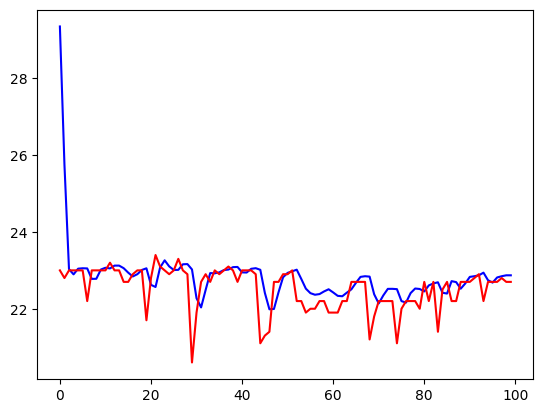

In [2294]:
plt.plot(train_results1['Train Predictions'][:100], color='blue', label='Predictions')
plt.plot(train_results1['Actuals'][:100], color='red', label='Actuals')

In [2295]:
val_preds1 = model1.predict(X1_val).flatten()
val_results1 = pd.DataFrame(data ={'Validation Predictions': val_preds1, 'Actuals': y1_val})
val_results1

181/181 [==============================] - 0s 597us/step


,Validation Predictions,Actuals
0,23.012943,22.9
1,22.979359,22.9
2,22.976137,22.9
3,22.978115,23.0
4,23.013786,23.0
...,...,...
5783,29.783438,30.6
5784,29.767591,30.6
5785,29.762999,30.8
5786,29.786711,30.6


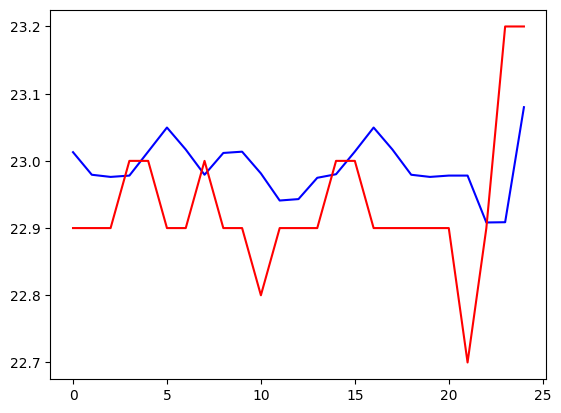

In [2296]:
plt.plot(val_results1['Validation Predictions'][:25], color='blue')
plt.plot(val_results1['Actuals'][:25], color='red')

In [2297]:
test_preds1 = model1.predict(X1_test).flatten()
test_results1 = pd.DataFrame(data ={'Test Predictions': test_preds1, 'Actuals': y1_test})
test_results1

91/91 [==============================] - 0s 591us/step


,Test Predictions,Actuals
0,29.763144,30.5
1,29.750298,30.4
2,29.732477,30.2
3,29.699568,30.3
4,29.702410,30.2
...,...,...
2890,28.037199,27.6
2891,27.931362,27.6
2892,27.890825,27.4
2893,27.761612,27.4


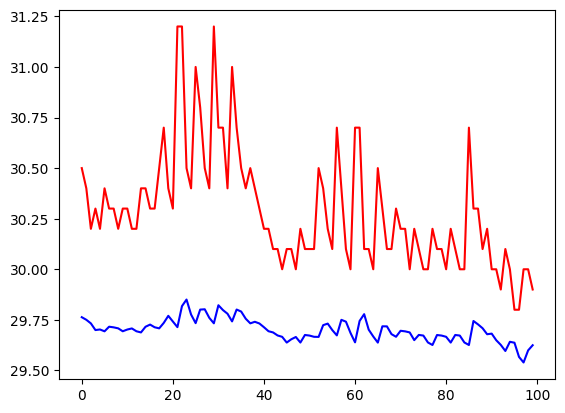

In [2298]:
plt.plot(test_results1['Test Predictions'][:100], color='blue')
plt.plot(test_results1['Actuals'][:100], color='red')

In [2299]:
def plot_predictions(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data ={'Predictions': predictions, 'Actuals': y})
    plt.plot(df['Predictions'][start:end], color='blue', label='Predictions')
    plt.plot(df['Actuals'][start:end], color='red', label='Actuals')
    plt.legend()
    return df, mse(y, predictions)

 1/91 [..............................] - ETA: 1s

91/91 [==============================] - 0s 833us/step


(      Predictions  Actuals
 0       29.763144     30.5
 1       29.750298     30.4
 2       29.732477     30.2
 3       29.699568     30.3
 4       29.702410     30.2
 ...           ...      ...
 2890    28.037199     27.6
 2891    27.931362     27.6
 2892    27.890825     27.4
 2893    27.761612     27.4
 2894    27.676451     27.4
 
 [2895 rows x 2 columns],
 0.17088379892715594)

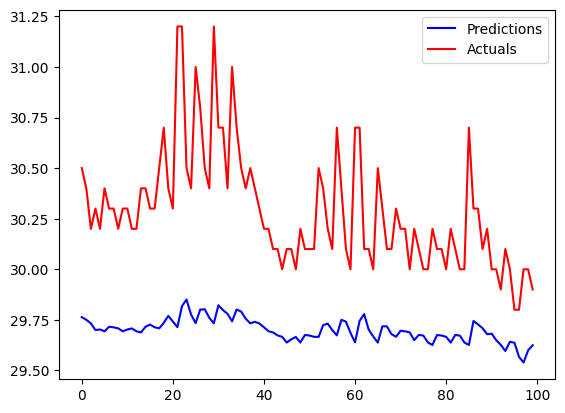

In [2300]:
plot_predictions(model1, X1_test, y1_test)

In [2301]:
model2 = Sequential()
model2.add(InputLayer((4, 1)))
model2.add(Conv1D(64, kernel_size=2, activation='relu'))
model2.add(Flatten())
model2.add(Dense(8, 'ReLU'))
model2.add(Dense(1, 'linear'))
model2.summary()

Model: "sequential_201"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_55 (Conv1D)          (None, 3, 64)             192       
                                                                 
 flatten_97 (Flatten)        (None, 192)               0         
                                                                 
 dense_400 (Dense)           (None, 8)                 1544      
                                                                 
 dense_401 (Dense)           (None, 1)                 9         
                                                                 
Total params: 1745 (6.82 KB)
Trainable params: 1745 (6.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [2302]:
cp2 = ModelCheckpoint('model2/', SAVE_BEST_ONLY=True, verbose=0)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [2303]:
model2.fit(X1_train, y1_train, epochs=10, validation_data=(X1_val, y1_val), callbacks=[cp2])

Epoch 1/10
617/634 [============================>.] - ETA: 0s - loss: 92.7286 - root_mean_squared_error: 9.6296  INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


634/634 [==============================] - 1s 1ms/step - loss: 90.3697 - root_mean_squared_error: 9.5063 - val_loss: 0.0912 - val_root_mean_squared_error: 0.3020
Epoch 2/10
634/634 [==============================] - ETA: 0s - loss: 0.1164 - root_mean_squared_error: 0.3412INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


634/634 [==============================] - 1s 801us/step - loss: 0.1164 - root_mean_squared_error: 0.3412 - val_loss: 0.0898 - val_root_mean_squared_error: 0.2997
Epoch 3/10
627/634 [============================>.] - ETA: 0s - loss: 0.1164 - root_mean_squared_error: 0.3412INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


634/634 [==============================] - 1s 829us/step - loss: 0.1160 - root_mean_squared_error: 0.3406 - val_loss: 0.0899 - val_root_mean_squared_error: 0.2998
Epoch 4/10
631/634 [============================>.] - ETA: 0s - loss: 0.1157 - root_mean_squared_error: 0.3402INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


634/634 [==============================] - 1s 906us/step - loss: 0.1158 - root_mean_squared_error: 0.3404 - val_loss: 0.0894 - val_root_mean_squared_error: 0.2991
Epoch 5/10
626/634 [============================>.] - ETA: 0s - loss: 0.1161 - root_mean_squared_error: 0.3407INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


634/634 [==============================] - 1s 806us/step - loss: 0.1157 - root_mean_squared_error: 0.3402 - val_loss: 0.0893 - val_root_mean_squared_error: 0.2988
Epoch 6/10
509/634 [=======================>......] - ETA: 0s - loss: 0.1163 - root_mean_squared_error: 0.3411INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


634/634 [==============================] - 1s 817us/step - loss: 0.1155 - root_mean_squared_error: 0.3398 - val_loss: 0.0898 - val_root_mean_squared_error: 0.2996
Epoch 7/10
629/634 [============================>.] - ETA: 0s - loss: 0.1153 - root_mean_squared_error: 0.3396INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


634/634 [==============================] - 1s 802us/step - loss: 0.1152 - root_mean_squared_error: 0.3394 - val_loss: 0.0894 - val_root_mean_squared_error: 0.2990
Epoch 8/10
509/634 [=======================>......] - ETA: 0s - loss: 0.1131 - root_mean_squared_error: 0.3363INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


634/634 [==============================] - 1s 797us/step - loss: 0.1148 - root_mean_squared_error: 0.3388 - val_loss: 0.0883 - val_root_mean_squared_error: 0.2972
Epoch 9/10
620/634 [============================>.] - ETA: 0s - loss: 0.1148 - root_mean_squared_error: 0.3388INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


634/634 [==============================] - 1s 809us/step - loss: 0.1144 - root_mean_squared_error: 0.3383 - val_loss: 0.0880 - val_root_mean_squared_error: 0.2966
Epoch 10/10
633/634 [============================>.] - ETA: 0s - loss: 0.1141 - root_mean_squared_error: 0.3378INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


634/634 [==============================] - 1s 805us/step - loss: 0.1141 - root_mean_squared_error: 0.3378 - val_loss: 0.0884 - val_root_mean_squared_error: 0.2973


91/91 [==============================] - 0s 303us/step


(      Predictions  Actuals
 0       30.609316     30.5
 1       30.536919     30.4
 2       30.457977     30.2
 3       30.342358     30.3
 4       30.291491     30.2
 ...           ...      ...
 2890    27.817513     27.6
 2891    27.713760     27.6
 2892    27.631142     27.4
 2893    27.515812     27.4
 2894    27.468622     27.4
 
 [2895 rows x 2 columns],
 0.058714504935338196)

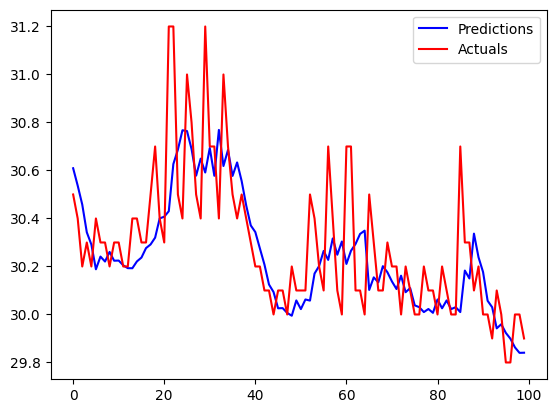

In [2304]:
plot_predictions(model2, X1_test, y1_test)

In [2305]:
model3 = Sequential()
model3.add(InputLayer((4, 1)))
model3.add(GRU(64))
model3.add(Flatten())
model3.add(Dense(8, 'ReLU'))
model3.add(Dense(1, 'linear'))
model3.summary()

Model: "sequential_202"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_42 (GRU)                (None, 64)                12864     
                                                                 
 flatten_98 (Flatten)        (None, 64)                0         
                                                                 
 dense_402 (Dense)           (None, 8)                 520       
                                                                 
 dense_403 (Dense)           (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [2306]:
cp3 = ModelCheckpoint('model3/', SAVE_BEST_ONLY=True, verbose=0)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model3.fit(X1_train, y1_train, epochs=10, validation_data=(X1_val, y1_val), callbacks=[cp3])

Epoch 1/10
630/634 [============================>.] - ETA: 0s - loss: 474.2042 - root_mean_squared_error: 21.7762INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


634/634 [==============================] - 3s 4ms/step - loss: 473.3201 - root_mean_squared_error: 21.7559 - val_loss: 296.4897 - val_root_mean_squared_error: 17.2189
Epoch 2/10
627/634 [============================>.] - ETA: 0s - loss: 168.5917 - root_mean_squared_error: 12.9843INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


634/634 [==============================] - 2s 3ms/step - loss: 167.8638 - root_mean_squared_error: 12.9562 - val_loss: 97.7479 - val_root_mean_squared_error: 9.8868
Epoch 3/10
629/634 [============================>.] - ETA: 0s - loss: 50.5864 - root_mean_squared_error: 7.1124INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


634/634 [==============================] - 2s 3ms/step - loss: 50.4209 - root_mean_squared_error: 7.1008 - val_loss: 28.4720 - val_root_mean_squared_error: 5.3359
Epoch 4/10
624/634 [============================>.] - ETA: 0s - loss: 14.4499 - root_mean_squared_error: 3.8013INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


634/634 [==============================] - 2s 3ms/step - loss: 14.3747 - root_mean_squared_error: 3.7914 - val_loss: 11.4068 - val_root_mean_squared_error: 3.3774
Epoch 5/10
630/634 [============================>.] - ETA: 0s - loss: 8.3517 - root_mean_squared_error: 2.8899INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


634/634 [==============================] - 2s 3ms/step - loss: 8.3512 - root_mean_squared_error: 2.8898 - val_loss: 9.3157 - val_root_mean_squared_error: 3.0522
Epoch 6/10
629/634 [============================>.] - ETA: 0s - loss: 7.0226 - root_mean_squared_error: 2.6500INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


634/634 [==============================] - 2s 3ms/step - loss: 7.0047 - root_mean_squared_error: 2.6466 - val_loss: 5.7733 - val_root_mean_squared_error: 2.4028
Epoch 7/10
601/634 [===========================>..] - ETA: 0s - loss: 2.1772 - root_mean_squared_error: 1.4755INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


634/634 [==============================] - 2s 4ms/step - loss: 2.1064 - root_mean_squared_error: 1.4514 - val_loss: 1.1015 - val_root_mean_squared_error: 1.0495
Epoch 8/10
628/634 [============================>.] - ETA: 0s - loss: 0.4486 - root_mean_squared_error: 0.6698INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


634/634 [==============================] - 2s 3ms/step - loss: 0.4471 - root_mean_squared_error: 0.6687 - val_loss: 0.3846 - val_root_mean_squared_error: 0.6201
Epoch 9/10
618/634 [============================>.] - ETA: 0s - loss: 0.2084 - root_mean_squared_error: 0.4565INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


634/634 [==============================] - 2s 3ms/step - loss: 0.2075 - root_mean_squared_error: 0.4556 - val_loss: 0.2114 - val_root_mean_squared_error: 0.4598
Epoch 10/10
632/634 [============================>.] - ETA: 0s - loss: 0.1576 - root_mean_squared_error: 0.3970INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


634/634 [==============================] - 2s 3ms/step - loss: 0.1576 - root_mean_squared_error: 0.3970 - val_loss: 0.1624 - val_root_mean_squared_error: 0.4030


91/91 [==============================] - 0s 522us/step


(      Predictions  Actuals
 0       29.981674     30.5
 1       29.959755     30.4
 2       29.935062     30.2
 3       29.881689     30.3
 4       29.902048     30.2
 ...           ...      ...
 2890    27.895926     27.6
 2891    27.794682     27.6
 2892    27.769932     27.4
 2893    27.615816     27.4
 2894    27.569263     27.4
 
 [2895 rows x 2 columns],
 0.11199974295956207)

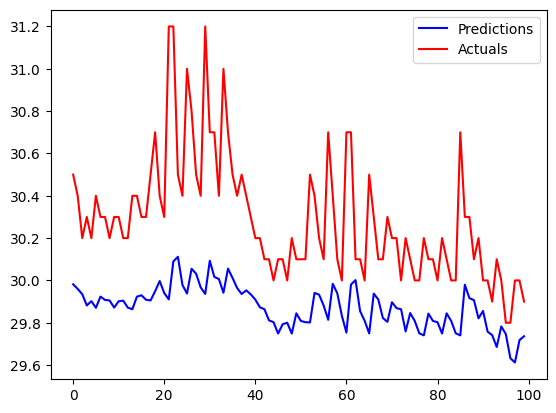

In [2307]:
plot_predictions(model3, X1_test, y1_test)

### Conv1D > GRU > LSTM - because of parameter size

# Multivariate Section

### Need to see df without scrolling up

In [2308]:
df

,wind dir (deg),wind spd (m/s),wind gst (m/s),wave hgt (ft),mean wave dir (deg),air pres (ft),air temp (deg fah),water temp (deg fah)
timestamp,,,,,,,,
1994-08-17 18:00:00-05:00,185.0,6.0,7.6,0.50,168.0,1016.5,29.7,29.7
1994-08-18 00:00:00-05:00,325.0,0.7,1.3,0.60,128.0,1015.1,30.7,29.9
1994-08-18 06:00:00-05:00,132.0,7.1,8.8,0.80,73.0,1016.4,28.6,29.7
1994-08-18 12:00:00-05:00,180.0,6.0,7.1,1.10,153.0,1016.1,29.0,29.3
1995-02-01 06:00:00-05:00,159.0,4.6,6.1,0.40,17.0,1020.2,17.5,23.0
...,...,...,...,...,...,...,...,...
2022-10-20 00:40:00-05:00,8.0,6.4,9.9,1.51,18.0,1022.7,19.6,27.6
2022-10-20 06:40:00-05:00,9.0,4.0,6.6,1.07,56.0,1022.3,19.7,27.6
2022-10-20 12:40:00-05:00,11.0,3.9,6.2,0.93,63.0,1020.7,20.3,27.4


### We should make the timestamp column relative in a unit of time. We need this to make sin and cos curves

In [2309]:
def get_relative_minutes(df):
    min_df = df.copy()
    min_df['minutes'] = min_df.index.map(lambda x: x.timestamp() / 60)
    return min_df
df = get_relative_minutes(df)
df

,wind dir (deg),wind spd (m/s),wind gst (m/s),wave hgt (ft),mean wave dir (deg),air pres (ft),air temp (deg fah),water temp (deg fah),minutes
timestamp,,,,,,,,,
1994-08-17 18:00:00-05:00,185.0,6.0,7.6,0.50,168.0,1016.5,29.7,29.7,12952740.0
1994-08-18 00:00:00-05:00,325.0,0.7,1.3,0.60,128.0,1015.1,30.7,29.9,12953100.0
1994-08-18 06:00:00-05:00,132.0,7.1,8.8,0.80,73.0,1016.4,28.6,29.7,12953460.0
1994-08-18 12:00:00-05:00,180.0,6.0,7.1,1.10,153.0,1016.1,29.0,29.3,12953820.0
1995-02-01 06:00:00-05:00,159.0,4.6,6.1,0.40,17.0,1020.2,17.5,23.0,13193940.0
...,...,...,...,...,...,...,...,...,...
2022-10-20 00:40:00-05:00,8.0,6.4,9.9,1.51,18.0,1022.7,19.6,27.6,27770740.0
2022-10-20 06:40:00-05:00,9.0,4.0,6.6,1.07,56.0,1022.3,19.7,27.6,27771100.0
2022-10-20 12:40:00-05:00,11.0,3.9,6.2,0.93,63.0,1020.7,20.3,27.4,27771460.0


In [2310]:
day = 60*24
year = 365.2425*day
df['Day sin'] = np.sin(df['minutes'] * (2 * np.pi / day))
df['Day cos'] = np.cos(df['minutes'] * (2 * np.pi / day))
df['Year sin'] = np.sin(df['minutes'] * (2 * np.pi / year))
df['Year cos'] = np.cos(df['minutes'] * (2 * np.pi / year))
df

,wind dir (deg),wind spd (m/s),wind gst (m/s),wave hgt (ft),mean wave dir (deg),air pres (ft),air temp (deg fah),water temp (deg fah),minutes,Day sin,Day cos,Year sin,Year cos
timestamp,,,,,,,,,,,,,
1994-08-17 18:00:00-05:00,185.0,6.0,7.6,0.50,168.0,1016.5,29.7,29.7,12952740.0,-0.258819,0.965926,-0.717511,-0.696547
1994-08-18 00:00:00-05:00,325.0,0.7,1.3,0.60,128.0,1015.1,30.7,29.9,12953100.0,0.965926,0.258819,-0.720500,-0.693454
1994-08-18 06:00:00-05:00,132.0,7.1,8.8,0.80,73.0,1016.4,28.6,29.7,12953460.0,0.258819,-0.965926,-0.723476,-0.690349
1994-08-18 12:00:00-05:00,180.0,6.0,7.1,1.10,153.0,1016.1,29.0,29.3,12953820.0,-0.965926,-0.258819,-0.726438,-0.687232
1995-02-01 06:00:00-05:00,159.0,4.6,6.1,0.40,17.0,1020.2,17.5,23.0,13193940.0,0.258819,-0.965926,0.514218,0.857660
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-20 00:40:00-05:00,8.0,6.4,9.9,1.51,18.0,1022.7,19.6,27.6,27770740.0,0.996195,0.087156,-0.948733,0.316078
2022-10-20 06:40:00-05:00,9.0,4.0,6.6,1.07,56.0,1022.3,19.7,27.6,27771100.0,0.087156,-0.996195,-0.947365,0.320155
2022-10-20 12:40:00-05:00,11.0,3.9,6.2,0.93,63.0,1020.7,20.3,27.4,27771460.0,-0.996195,-0.087156,-0.945979,0.324227


### we can remove the minutes column now that we have periodic values sin and cos

In [2311]:
df = df.drop(['minutes'], axis=1)

In [2312]:
def prediction_2(df, window=4):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range (len(df_as_np) - window):
        row = [a for a in df_as_np[i:i+window]]
        X.append(row)
        label = df_as_np[i+window][0]
        y.append(label)
    return np.array(X), np.array(y)

In [2313]:
df2 = df.loc[:, ['water temp (deg fah)', 'Day sin', 'Day cos', 'Year sin', 'Year cos']]
df2

,water temp (deg fah),Day sin,Day cos,Year sin,Year cos
timestamp,,,,,
1994-08-17 18:00:00-05:00,29.7,-0.258819,0.965926,-0.717511,-0.696547
1994-08-18 00:00:00-05:00,29.9,0.965926,0.258819,-0.720500,-0.693454
1994-08-18 06:00:00-05:00,29.7,0.258819,-0.965926,-0.723476,-0.690349
1994-08-18 12:00:00-05:00,29.3,-0.965926,-0.258819,-0.726438,-0.687232
1995-02-01 06:00:00-05:00,23.0,0.258819,-0.965926,0.514218,0.857660
...,...,...,...,...,...
2022-10-20 00:40:00-05:00,27.6,0.996195,0.087156,-0.948733,0.316078
2022-10-20 06:40:00-05:00,27.6,0.087156,-0.996195,-0.947365,0.320155
2022-10-20 12:40:00-05:00,27.4,-0.996195,-0.087156,-0.945979,0.324227


In [2314]:
X2, y2 = prediction_2(df2)
X2.shape, y2.shape


((28943, 4, 5), (28943,))

In [2315]:
X2_train, y2_train = X2[:int(0.7*len(X2))], y2[:int(0.7*len(y2))] #first 80 for train
X2_val, y2_val = X2[int(0.7*len(X2)):int(0.9*len(X2))], y2[int(0.7*len(y2)):int(0.9*len(y2))] #70 to 90 for validation
X2_test, y2_test = X2[int(0.9*len(X2)):], y2[int(0.9*len(y2)):] #last 10 for test

### Bring water temp into the same scale as the sin and cos values

In [2316]:
temp_training_mean = np.mean(X2_train[:, :, 0])
temp_training_std = np.std(X2_train[:, :, 0])

def preprocess(X):
    X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
    return X


In [2317]:
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)

array([[[ 1.51388861, -0.99904822, -0.04361939, -0.77166725,
         -0.63602646],
        [ 1.58481004, -0.04361939,  0.99904822, -0.77439546,
         -0.63270188],
        [ 1.51388861,  0.99904822,  0.04361939, -0.77710935,
         -0.6293656 ],
        [ 1.51388861,  0.04361939, -0.99904822, -0.77980886,
         -0.62601768]],

       [[ 1.58481004, -0.04361939,  0.99904822, -0.77439546,
         -0.63270188],
        [ 1.51388861,  0.99904822,  0.04361939, -0.77710935,
         -0.6293656 ],
        [ 1.51388861,  0.04361939, -0.99904822, -0.77980886,
         -0.62601768],
        [ 1.47842789, -0.99904822, -0.04361939, -0.78249395,
         -0.62265819]],

       [[ 1.51388861,  0.99904822,  0.04361939, -0.77710935,
         -0.6293656 ],
        [ 1.51388861,  0.04361939, -0.99904822, -0.77980886,
         -0.62601768],
        [ 1.47842789, -0.99904822, -0.04361939, -0.78249395,
         -0.62265819],
        [ 1.44296717, -0.04361939,  0.99904822, -0.78516457,
         -0

In [2318]:
model4 = Sequential()
model4.add(InputLayer((4, 5)))
model4.add(LSTM(64))
model4.add(Dense(8, 'ReLU'))
model4.add(Dense(1, 'linear'))
model4.summary()

Model: "sequential_203"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_116 (LSTM)             (None, 64)                17920     
                                                                 
 dense_404 (Dense)           (None, 8)                 520       
                                                                 
 dense_405 (Dense)           (None, 1)                 9         
                                                                 
Total params: 18449 (72.07 KB)
Trainable params: 18449 (72.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [2319]:
cp4 = ModelCheckpoint('model4/', SAVE_BEST_ONLY=True, verbose=0)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model4.fit(X2_train, y2_train, epochs=20, validation_data=(X2_val, y2_val), callbacks=[cp4])

Epoch 1/20
596/634 [===========================>..] - ETA: 0s - loss: 605.5861 - root_mean_squared_error: 24.6087INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


634/634 [==============================] - 3s 4ms/step - loss: 594.0143 - root_mean_squared_error: 24.3724 - val_loss: 404.0270 - val_root_mean_squared_error: 20.1004
Epoch 2/20
596/634 [===========================>..] - ETA: 0s - loss: 200.5071 - root_mean_squared_error: 14.1601INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


634/634 [==============================] - 2s 3ms/step - loss: 190.5388 - root_mean_squared_error: 13.8036 - val_loss: 29.8200 - val_root_mean_squared_error: 5.4608
Epoch 3/20
633/634 [============================>.] - ETA: 0s - loss: 5.6716 - root_mean_squared_error: 2.3815INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


634/634 [==============================] - 2s 3ms/step - loss: 5.6706 - root_mean_squared_error: 2.3813 - val_loss: 0.9101 - val_root_mean_squared_error: 0.9540
Epoch 4/20
625/634 [============================>.] - ETA: 0s - loss: 0.6497 - root_mean_squared_error: 0.8060INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


634/634 [==============================] - 7s 10ms/step - loss: 0.6482 - root_mean_squared_error: 0.8051 - val_loss: 0.6437 - val_root_mean_squared_error: 0.8023
Epoch 5/20
625/634 [============================>.] - ETA: 0s - loss: 0.4375 - root_mean_squared_error: 0.6614INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


634/634 [==============================] - 2s 3ms/step - loss: 0.4360 - root_mean_squared_error: 0.6603 - val_loss: 0.4759 - val_root_mean_squared_error: 0.6899
Epoch 6/20
629/634 [============================>.] - ETA: 0s - loss: 0.3200 - root_mean_squared_error: 0.5657INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


634/634 [==============================] - 2s 3ms/step - loss: 0.3197 - root_mean_squared_error: 0.5654 - val_loss: 0.3548 - val_root_mean_squared_error: 0.5956
Epoch 7/20
632/634 [============================>.] - ETA: 0s - loss: 0.2511 - root_mean_squared_error: 0.5011INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


634/634 [==============================] - 2s 4ms/step - loss: 0.2510 - root_mean_squared_error: 0.5010 - val_loss: 0.2786 - val_root_mean_squared_error: 0.5279
Epoch 8/20
632/634 [============================>.] - ETA: 0s - loss: 0.2081 - root_mean_squared_error: 0.4561INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


634/634 [==============================] - 2s 4ms/step - loss: 0.2079 - root_mean_squared_error: 0.4559 - val_loss: 0.2237 - val_root_mean_squared_error: 0.4730
Epoch 9/20
634/634 [==============================] - ETA: 0s - loss: 0.1768 - root_mean_squared_error: 0.4204INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


634/634 [==============================] - 2s 4ms/step - loss: 0.1768 - root_mean_squared_error: 0.4204 - val_loss: 0.1847 - val_root_mean_squared_error: 0.4298
Epoch 10/20
622/634 [============================>.] - ETA: 0s - loss: 0.1567 - root_mean_squared_error: 0.3958INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


634/634 [==============================] - 2s 4ms/step - loss: 0.1561 - root_mean_squared_error: 0.3951 - val_loss: 0.1681 - val_root_mean_squared_error: 0.4099
Epoch 11/20
633/634 [============================>.] - ETA: 0s - loss: 0.1428 - root_mean_squared_error: 0.3778INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


634/634 [==============================] - 2s 3ms/step - loss: 0.1427 - root_mean_squared_error: 0.3778 - val_loss: 0.1452 - val_root_mean_squared_error: 0.3811
Epoch 12/20
602/634 [===========================>..] - ETA: 0s - loss: 0.1354 - root_mean_squared_error: 0.3679INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


634/634 [==============================] - 2s 3ms/step - loss: 0.1343 - root_mean_squared_error: 0.3664 - val_loss: 0.1427 - val_root_mean_squared_error: 0.3777
Epoch 13/20
601/634 [===========================>..] - ETA: 0s - loss: 0.1300 - root_mean_squared_error: 0.3606INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


634/634 [==============================] - 2s 3ms/step - loss: 0.1285 - root_mean_squared_error: 0.3585 - val_loss: 0.1316 - val_root_mean_squared_error: 0.3628
Epoch 14/20
598/634 [===========================>..] - ETA: 0s - loss: 0.1259 - root_mean_squared_error: 0.3548INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


634/634 [==============================] - 2s 3ms/step - loss: 0.1240 - root_mean_squared_error: 0.3522 - val_loss: 0.1207 - val_root_mean_squared_error: 0.3474
Epoch 15/20
597/634 [===========================>..] - ETA: 0s - loss: 0.1215 - root_mean_squared_error: 0.3486INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


634/634 [==============================] - 2s 3ms/step - loss: 0.1202 - root_mean_squared_error: 0.3467 - val_loss: 0.1257 - val_root_mean_squared_error: 0.3545
Epoch 16/20
598/634 [===========================>..] - ETA: 0s - loss: 0.1149 - root_mean_squared_error: 0.3390INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


634/634 [==============================] - 2s 3ms/step - loss: 0.1163 - root_mean_squared_error: 0.3411 - val_loss: 0.1049 - val_root_mean_squared_error: 0.3239
Epoch 17/20
600/634 [===========================>..] - ETA: 0s - loss: 0.1145 - root_mean_squared_error: 0.3383INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


634/634 [==============================] - 2s 4ms/step - loss: 0.1135 - root_mean_squared_error: 0.3369 - val_loss: 0.1051 - val_root_mean_squared_error: 0.3243
Epoch 18/20
614/634 [============================>.] - ETA: 0s - loss: 0.1079 - root_mean_squared_error: 0.3284INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


634/634 [==============================] - 3s 4ms/step - loss: 0.1099 - root_mean_squared_error: 0.3315 - val_loss: 0.1071 - val_root_mean_squared_error: 0.3272
Epoch 19/20
615/634 [============================>.] - ETA: 0s - loss: 0.1061 - root_mean_squared_error: 0.3258INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


634/634 [==============================] - 3s 4ms/step - loss: 0.1067 - root_mean_squared_error: 0.3267 - val_loss: 0.0978 - val_root_mean_squared_error: 0.3127
Epoch 20/20
609/634 [===========================>..] - ETA: 0s - loss: 0.1042 - root_mean_squared_error: 0.3228INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


634/634 [==============================] - 2s 4ms/step - loss: 0.1041 - root_mean_squared_error: 0.3226 - val_loss: 0.0929 - val_root_mean_squared_error: 0.3047


91/91 [==============================] - 0s 640us/step


(      Predictions  Actuals
 0       30.331026     30.5
 1       30.670826     30.4
 2       30.584866     30.2
 3       30.184780     30.3
 4       30.148987     30.2
 ...           ...      ...
 2890    27.910927     27.6
 2891    27.699780     27.6
 2892    27.571808     27.4
 2893    27.670200     27.4
 2894    27.608677     27.4
 
 [2895 rows x 2 columns],
 0.07102296756998742)

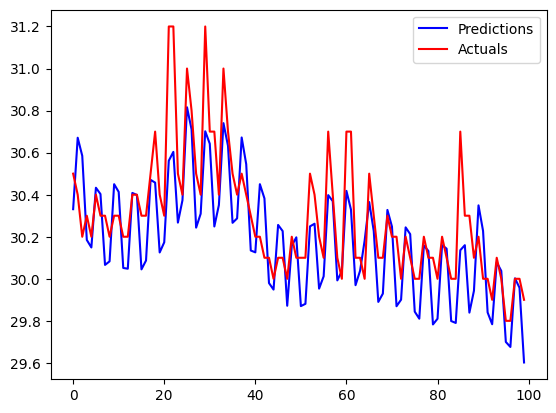

In [2320]:
plot_predictions(model4, X2_test, y2_test)

In [2321]:
df

,wind dir (deg),wind spd (m/s),wind gst (m/s),wave hgt (ft),mean wave dir (deg),air pres (ft),air temp (deg fah),water temp (deg fah),Day sin,Day cos,Year sin,Year cos
timestamp,,,,,,,,,,,,
1994-08-17 18:00:00-05:00,185.0,6.0,7.6,0.50,168.0,1016.5,29.7,29.7,-0.258819,0.965926,-0.717511,-0.696547
1994-08-18 00:00:00-05:00,325.0,0.7,1.3,0.60,128.0,1015.1,30.7,29.9,0.965926,0.258819,-0.720500,-0.693454
1994-08-18 06:00:00-05:00,132.0,7.1,8.8,0.80,73.0,1016.4,28.6,29.7,0.258819,-0.965926,-0.723476,-0.690349
1994-08-18 12:00:00-05:00,180.0,6.0,7.1,1.10,153.0,1016.1,29.0,29.3,-0.965926,-0.258819,-0.726438,-0.687232
1995-02-01 06:00:00-05:00,159.0,4.6,6.1,0.40,17.0,1020.2,17.5,23.0,0.258819,-0.965926,0.514218,0.857660
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-20 00:40:00-05:00,8.0,6.4,9.9,1.51,18.0,1022.7,19.6,27.6,0.996195,0.087156,-0.948733,0.316078
2022-10-20 06:40:00-05:00,9.0,4.0,6.6,1.07,56.0,1022.3,19.7,27.6,0.087156,-0.996195,-0.947365,0.320155
2022-10-20 12:40:00-05:00,11.0,3.9,6.2,0.93,63.0,1020.7,20.3,27.4,-0.996195,-0.087156,-0.945979,0.324227


### Add another predictive variable

In [2322]:
def prediction_two_var(df, window=4):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range (len(df_as_np) - window):
        row = [a for a in df_as_np[i:i+window]]
        X.append(row)
        label = [df_as_np[i+window][0], df_as_np[i+window][1]]
        y.append(label)
    return np.array(X), np.array(y)

In [2323]:
df3 = df.loc[:, ['wave hgt (ft)', 'water temp (deg fah)', 'Day sin', 'Day cos', 'Year sin', 'Year cos', ]]

In [2324]:
df3

,wave hgt (ft),water temp (deg fah),Day sin,Day cos,Year sin,Year cos
timestamp,,,,,,
1994-08-17 18:00:00-05:00,0.50,29.7,-0.258819,0.965926,-0.717511,-0.696547
1994-08-18 00:00:00-05:00,0.60,29.9,0.965926,0.258819,-0.720500,-0.693454
1994-08-18 06:00:00-05:00,0.80,29.7,0.258819,-0.965926,-0.723476,-0.690349
1994-08-18 12:00:00-05:00,1.10,29.3,-0.965926,-0.258819,-0.726438,-0.687232
1995-02-01 06:00:00-05:00,0.40,23.0,0.258819,-0.965926,0.514218,0.857660
...,...,...,...,...,...,...
2022-10-20 00:40:00-05:00,1.51,27.6,0.996195,0.087156,-0.948733,0.316078
2022-10-20 06:40:00-05:00,1.07,27.6,0.087156,-0.996195,-0.947365,0.320155
2022-10-20 12:40:00-05:00,0.93,27.4,-0.996195,-0.087156,-0.945979,0.324227


In [2325]:
X3, y3 = prediction_two_var(df3)
X3.shape, y3.shape

((28943, 4, 6), (28943, 2))

In [2326]:
X3_train, y3_train = X3[:int(0.7*len(X3))], y3[:int(0.7*len(y3))] #first 80 for train
X3_val, y3_val = X3[int(0.7*len(X3)):int(0.9*len(X3))], y3[int(0.7*len(y3)):int(0.9*len(y3))] #70 to 90 for validation
X3_test, y3_test = X3[int(0.9*len(X3)):], y3[int(0.9*len(y3)):] #last 10 for test

In [2327]:
wave_hgt_training_mean = np.mean(X3_train[:, :, 0])
wave_hgt_training_std = np.std(X3_train[:, :, 0])
temp_training_mean = np.mean(X3_train[:, :, 1])
temp_training_std = np.std(X3_train[:, :, 1])

def preprocess_input(X):
    X[:, :, 0] = (X[:, :, 0] - wave_hgt_training_mean) / wave_hgt_training_std
    X[:, :, 1] = (X[:, :, 1] - temp_training_mean) / temp_training_std
    
    return X

def preprocess_output(y):
    y[:, 0] = (y[:, 0] - wave_hgt_training_mean) / wave_hgt_training_std
    y[:, 1] = (y[:, 1] - temp_training_mean) / temp_training_std
    return y

In [2328]:
preprocess_input(X3_train)
preprocess_input(X3_val)
preprocess_input(X3_test)
preprocess_output(y3_train)
preprocess_output(y3_val)
preprocess_output(y3_test)

array([[-0.24767699,  1.47842789],
       [ 0.60583599,  1.44296717],
       [-0.12174884,  1.37204574],
       ...,
       [-0.47154924,  0.37914568],
       [-0.80735763,  0.37914568],
       [-1.11518198,  0.37914568]])

In [2329]:
model5 = Sequential()
model5.add(InputLayer((4, 6)))
model5.add(LSTM(64))
model5.add(Dense(8, 'ReLU'))
model5.add(Dense(2, 'linear'))
model5.summary()

Model: "sequential_204"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_117 (LSTM)             (None, 64)                18176     
                                                                 
 dense_406 (Dense)           (None, 8)                 520       
                                                                 
 dense_407 (Dense)           (None, 2)                 18        
                                                                 
Total params: 18714 (73.10 KB)
Trainable params: 18714 (73.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [2330]:
cp5 = ModelCheckpoint('model5/', SAVE_BEST_ONLY=True, verbose=0)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model5.fit(X3_train, y3_train, epochs=10, validation_data=(X3_val, y3_val), callbacks=[cp5])

Epoch 1/10
612/634 [===========================>..] - ETA: 0s - loss: 0.5103 - root_mean_squared_error: 0.7144INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 4s 4ms/step - loss: 0.5029 - root_mean_squared_error: 0.7091 - val_loss: 0.2429 - val_root_mean_squared_error: 0.4928
Epoch 2/10
613/634 [============================>.] - ETA: 0s - loss: 0.2374 - root_mean_squared_error: 0.4873INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 2s 4ms/step - loss: 0.2372 - root_mean_squared_error: 0.4871 - val_loss: 0.1696 - val_root_mean_squared_error: 0.4118
Epoch 3/10
629/634 [============================>.] - ETA: 0s - loss: 0.1786 - root_mean_squared_error: 0.4226INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 2s 4ms/step - loss: 0.1783 - root_mean_squared_error: 0.4223 - val_loss: 0.1291 - val_root_mean_squared_error: 0.3592
Epoch 4/10
613/634 [============================>.] - ETA: 0s - loss: 0.1381 - root_mean_squared_error: 0.3716INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 2s 4ms/step - loss: 0.1375 - root_mean_squared_error: 0.3708 - val_loss: 0.0991 - val_root_mean_squared_error: 0.3147
Epoch 5/10
603/634 [===========================>..] - ETA: 0s - loss: 0.1156 - root_mean_squared_error: 0.3400INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 2s 4ms/step - loss: 0.1160 - root_mean_squared_error: 0.3406 - val_loss: 0.0884 - val_root_mean_squared_error: 0.2972
Epoch 6/10
608/634 [===========================>..] - ETA: 0s - loss: 0.1085 - root_mean_squared_error: 0.3293INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 2s 4ms/step - loss: 0.1086 - root_mean_squared_error: 0.3296 - val_loss: 0.0841 - val_root_mean_squared_error: 0.2900
Epoch 7/10
604/634 [===========================>..] - ETA: 0s - loss: 0.1053 - root_mean_squared_error: 0.3245INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 2s 4ms/step - loss: 0.1047 - root_mean_squared_error: 0.3236 - val_loss: 0.0813 - val_root_mean_squared_error: 0.2850
Epoch 8/10
613/634 [============================>.] - ETA: 0s - loss: 0.1025 - root_mean_squared_error: 0.3202INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 2s 3ms/step - loss: 0.1025 - root_mean_squared_error: 0.3202 - val_loss: 0.0797 - val_root_mean_squared_error: 0.2823
Epoch 9/10
630/634 [============================>.] - ETA: 0s - loss: 0.1011 - root_mean_squared_error: 0.3180INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 3s 5ms/step - loss: 0.1011 - root_mean_squared_error: 0.3179 - val_loss: 0.0790 - val_root_mean_squared_error: 0.2810
Epoch 10/10
622/634 [============================>.] - ETA: 0s - loss: 0.1001 - root_mean_squared_error: 0.3164INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 3s 4ms/step - loss: 0.1004 - root_mean_squared_error: 0.3168 - val_loss: 0.0780 - val_root_mean_squared_error: 0.2794


In [2331]:
def postprocess_wave(arr):
    arr = (arr*wave_hgt_training_std) + wave_hgt_training_mean
    return arr
def postprocess_temp(arr):
    arr = (arr*temp_training_std) + temp_training_mean
    return arr

In [2332]:
def plot_all_predictions(model, X, y, start=0, end=100):
    predictions = model.predict(X)
    wv_preds, temp_preds = postprocess_wave(predictions[:, 0]), postprocess_temp(predictions[:, 1])
    wv_actuals, temp_actuals = postprocess_wave(y[:, 0]), postprocess_temp(y[:, 1])
    df = pd.DataFrame(data ={'Wave Height Predictions': wv_preds, 'Wave Height Actuals': wv_actuals, 'Temp Predictions': temp_preds, 'Temp Actuals': temp_actuals})
    plt.plot(df['Wave Height Predictions'][start:end], color='blue', label='Wave Height Predictions')
    plt.plot(df['Wave Height Actuals'][start:end], color='red', label='Wave Height Actuals')
    plt.plot(df['Temp Predictions'][start:end], color='green', label='Temp Predictions')
    plt.plot(df['Temp Actuals'][start:end], color='orange', label='Temp Actuals')
    return df[start:end]

91/91 [==============================] - 0s 563us/step


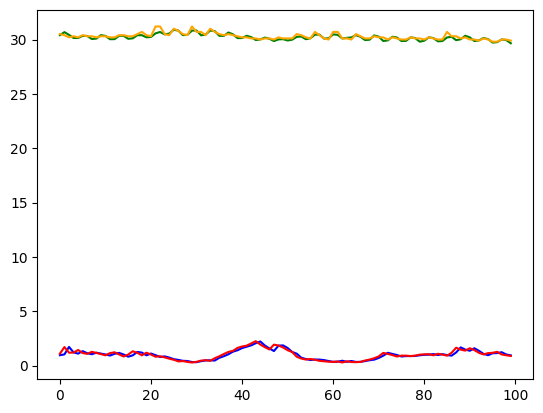

In [2333]:
post_processed_df = plot_all_predictions(model5, X3_test, y3_test)

In [2334]:
model6 = Sequential()
model6.add(InputLayer((4, 6)))
model6.add(LSTM(32, return_sequences=True))
model6.add(LSTM(64))
model6.add(Dense(8, 'ReLU'))
model6.add(Dense(2, 'linear'))
model6.summary()

Model: "sequential_205"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_118 (LSTM)             (None, 4, 32)             4992      
                                                                 
 lstm_119 (LSTM)             (None, 64)                24832     
                                                                 
 dense_408 (Dense)           (None, 8)                 520       
                                                                 
 dense_409 (Dense)           (None, 2)                 18        
                                                                 
Total params: 30362 (118.60 KB)
Trainable params: 30362 (118.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [2335]:
cp6 = ModelCheckpoint('model6/', SAVE_BEST_ONLY=True, verbose=0)
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model6.fit(X3_train, y3_train, epochs=10, validation_data=(X3_val, y3_val), callbacks=[cp5])

Epoch 1/10
621/634 [============================>.] - ETA: 0s - loss: 0.5607 - root_mean_squared_error: 0.7488INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 12s 16ms/step - loss: 0.5564 - root_mean_squared_error: 0.7459 - val_loss: 0.2638 - val_root_mean_squared_error: 0.5136
Epoch 2/10
616/634 [============================>.] - ETA: 0s - loss: 0.2662 - root_mean_squared_error: 0.5159INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 4s 7ms/step - loss: 0.2640 - root_mean_squared_error: 0.5138 - val_loss: 0.1936 - val_root_mean_squared_error: 0.4400
Epoch 3/10
626/634 [============================>.] - ETA: 0s - loss: 0.2052 - root_mean_squared_error: 0.4530INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 5s 7ms/step - loss: 0.2054 - root_mean_squared_error: 0.4532 - val_loss: 0.1488 - val_root_mean_squared_error: 0.3858
Epoch 4/10
623/634 [============================>.] - ETA: 0s - loss: 0.1487 - root_mean_squared_error: 0.3857INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 4s 6ms/step - loss: 0.1491 - root_mean_squared_error: 0.3861 - val_loss: 0.1041 - val_root_mean_squared_error: 0.3226
Epoch 5/10
632/634 [============================>.] - ETA: 0s - loss: 0.1189 - root_mean_squared_error: 0.3449INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 4s 6ms/step - loss: 0.1188 - root_mean_squared_error: 0.3447 - val_loss: 0.0904 - val_root_mean_squared_error: 0.3006
Epoch 6/10
613/634 [============================>.] - ETA: 0s - loss: 0.1096 - root_mean_squared_error: 0.3311INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 4s 7ms/step - loss: 0.1093 - root_mean_squared_error: 0.3306 - val_loss: 0.0839 - val_root_mean_squared_error: 0.2897
Epoch 7/10
633/634 [============================>.] - ETA: 0s - loss: 0.1051 - root_mean_squared_error: 0.3241INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 4s 7ms/step - loss: 0.1051 - root_mean_squared_error: 0.3241 - val_loss: 0.0811 - val_root_mean_squared_error: 0.2848
Epoch 8/10
630/634 [============================>.] - ETA: 0s - loss: 0.1034 - root_mean_squared_error: 0.3215INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 4s 6ms/step - loss: 0.1032 - root_mean_squared_error: 0.3213 - val_loss: 0.0797 - val_root_mean_squared_error: 0.2823
Epoch 9/10
625/634 [============================>.] - ETA: 0s - loss: 0.1025 - root_mean_squared_error: 0.3201INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 4s 6ms/step - loss: 0.1024 - root_mean_squared_error: 0.3200 - val_loss: 0.0799 - val_root_mean_squared_error: 0.2827
Epoch 10/10
623/634 [============================>.] - ETA: 0s - loss: 0.1021 - root_mean_squared_error: 0.3196INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 4s 6ms/step - loss: 0.1017 - root_mean_squared_error: 0.3190 - val_loss: 0.0795 - val_root_mean_squared_error: 0.2819


91/91 [==============================] - 1s 899us/step


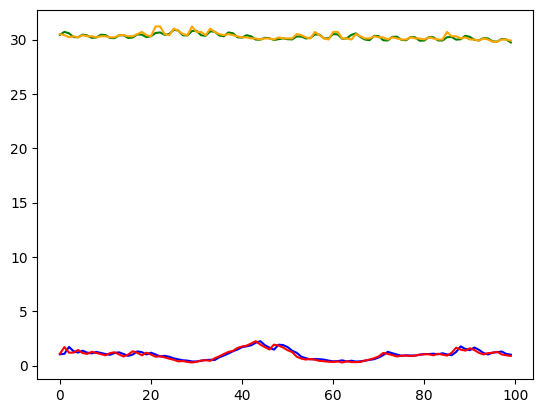

In [2336]:
post_processed_df = plot_all_predictions(model6, X3_test, y3_test)

In [2337]:
model7 = Sequential()
model7.add(InputLayer((4, 6)))
model7.add(Conv1D(64, kernel_size=2, activation='relu'))
model7.add(Flatten())
model7.add(Dense(8, 'ReLU'))
model7.add(Dense(2, 'linear'))
model7.summary()

Model: "sequential_206"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_56 (Conv1D)          (None, 3, 64)             832       
                                                                 


 flatten_99 (Flatten)        (None, 192)               0         
                                                                 
 dense_410 (Dense)           (None, 8)                 1544      
                                                                 
 dense_411 (Dense)           (None, 2)                 18        
                                                                 
Total params: 2394 (9.35 KB)
Trainable params: 2394 (9.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [2338]:
cp7 = ModelCheckpoint('model7/', SAVE_BEST_ONLY=True, verbose=0)
model7.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model7.fit(X3_train, y3_train, epochs=10, validation_data=(X3_val, y3_val), callbacks=[cp5])

Epoch 1/10
568/634 [=========================>....] - ETA: 0s - loss: 0.3833 - root_mean_squared_error: 0.6191INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 1s 1ms/step - loss: 0.3651 - root_mean_squared_error: 0.6042 - val_loss: 0.1657 - val_root_mean_squared_error: 0.4071
Epoch 2/10
554/634 [=========================>....] - ETA: 0s - loss: 0.1570 - root_mean_squared_error: 0.3963INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 1s 902us/step - loss: 0.1550 - root_mean_squared_error: 0.3937 - val_loss: 0.1118 - val_root_mean_squared_error: 0.3344
Epoch 3/10
586/634 [==========================>...] - ETA: 0s - loss: 0.1266 - root_mean_squared_error: 0.3558INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 1s 1ms/step - loss: 0.1262 - root_mean_squared_error: 0.3552 - val_loss: 0.0960 - val_root_mean_squared_error: 0.3098
Epoch 4/10
598/634 [===========================>..] - ETA: 0s - loss: 0.1145 - root_mean_squared_error: 0.3384INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 1s 970us/step - loss: 0.1144 - root_mean_squared_error: 0.3382 - val_loss: 0.0874 - val_root_mean_squared_error: 0.2956
Epoch 5/10
556/634 [=========================>....] - ETA: 0s - loss: 0.1103 - root_mean_squared_error: 0.3322INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 1s 874us/step - loss: 0.1083 - root_mean_squared_error: 0.3292 - val_loss: 0.0840 - val_root_mean_squared_error: 0.2897
Epoch 6/10
548/634 [========================>.....] - ETA: 0s - loss: 0.1058 - root_mean_squared_error: 0.3252INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 1s 873us/step - loss: 0.1051 - root_mean_squared_error: 0.3242 - val_loss: 0.0824 - val_root_mean_squared_error: 0.2871
Epoch 7/10
547/634 [========================>.....] - ETA: 0s - loss: 0.1034 - root_mean_squared_error: 0.3216INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 1s 908us/step - loss: 0.1032 - root_mean_squared_error: 0.3212 - val_loss: 0.0805 - val_root_mean_squared_error: 0.2838
Epoch 8/10
629/634 [============================>.] - ETA: 0s - loss: 0.1023 - root_mean_squared_error: 0.3198INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 1s 1ms/step - loss: 0.1023 - root_mean_squared_error: 0.3198 - val_loss: 0.0807 - val_root_mean_squared_error: 0.2841
Epoch 9/10
584/634 [==========================>...] - ETA: 0s - loss: 0.1020 - root_mean_squared_error: 0.3193INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 1s 994us/step - loss: 0.1015 - root_mean_squared_error: 0.3186 - val_loss: 0.0794 - val_root_mean_squared_error: 0.2818
Epoch 10/10
629/634 [============================>.] - ETA: 0s - loss: 0.1012 - root_mean_squared_error: 0.3181INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


634/634 [==============================] - 1s 920us/step - loss: 0.1009 - root_mean_squared_error: 0.3176 - val_loss: 0.0787 - val_root_mean_squared_error: 0.2806


91/91 [==============================] - 0s 336us/step


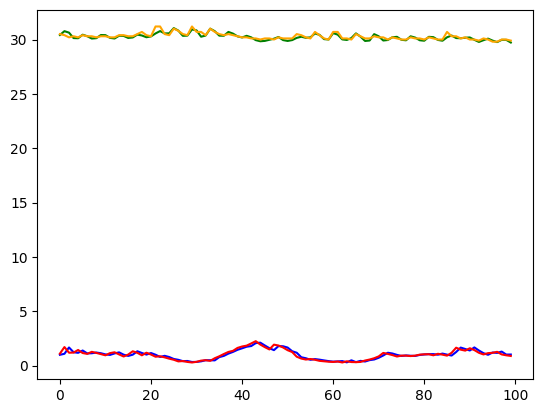

In [2339]:
post_processed_df = plot_all_predictions(model7, X3_test, y3_test)